In [1]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib2 # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [2]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib2.urlopen(website).read() # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site, "lxml") # Get the html from the site
    
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    

    text = soup_obj.get_text() # Get the text from this
    
        
    
    lines = (line.strip() for line in text.splitlines()) # break into lines
    
        
        
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  
        
    
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
        
        
    # Now clean out all of the unicode junk (this line works great!!!)
        
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
       
        
    text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
        
       
    text = text.lower().split()  # Go to lower case and split them apart
        
        
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
        
        
        
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)
        
    return text

In [3]:
def skills_info(state = None):
    '''
    This function will take a desired state and look for all new job postings
    on Indeed.ca. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
    
    Inputs: The location's state. These are optional. If no state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
    
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    
    if state is not None:
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', state] 
        # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string


    base_url = 'http://www.indeed.com'


    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html, "lxml") # Get the html from the first page

    # Now find out how many jobs there were

    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                         # The 'searchCount' object has this

    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result


    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 

    state_title = state
    if state is None:
        state_title = 'Nationwide'
    
    print 'There were', total_num_jobs, 'jobs found,', state_title # Display how many jobs were found

    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                  # search result page
    job_descriptions = [] # Store all our descriptions in this list

    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
        
        html_page = urllib2.urlopen(current_page).read() # Get the page
        
        page_obj = BeautifulSoup(html_page, "lxml") # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
        
        job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
        
    
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
    
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'


    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp

    # Now we can just look at our final dict list inside doc_frequency

    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for

    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                   'Ruby':doc_frequency['ruby'],
                  'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                  'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                  
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                      'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                      'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
               'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
               'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
               'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
               'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
               
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                 'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                 'MongoDB':doc_frequency['mongodb']})
                 
           
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects

    

    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 

    # Change the values to reflect a percentage of the postings 

    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                  #  having that term 

    # Sort the data for plotting purposes

    final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)

    # Get it ready for a bar plot
    
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                              title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + state_title)
    
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
    
    
    return fig, final_frame # End of the function

There were 19 jobs found, AZ
Getting page 1
Done with collecting the job postings!
There were 7 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


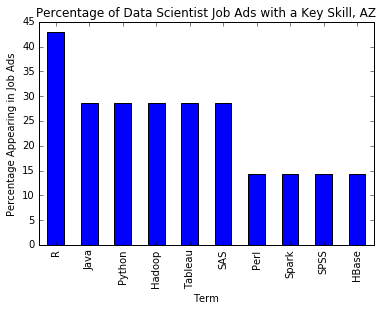

In [5]:
figure, frame = skills_info(state = 'AZ')
frame.to_csv('AZSkills.csv', index = False)

There were 791 jobs found, CA
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Getting page 35
Getting page 36
Getting page 37
Getting page 38
Getting page 39
Getting page 40
Getting page 41
Getting page 42
Getting page 43
Getting page 44
Getting page 45
Getting page 46
Getting page 47
Getting page 48
Getting page 49
Getting page 50
Getting page 51
Getting page 52
Getting page 53
Getting page 54
Getting page 55
Getting page 56
Getting page 57
Getting page 58
Getting page 59
Getting page 60
Getting page 61
Get

/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


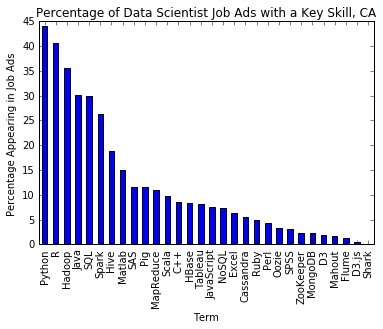

In [6]:
figure, frame = skills_info(state = 'CA')
frame.to_csv('CASkills.csv', index = False)

There were 54 jobs found, CO
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Done with collecting the job postings!
There were 34 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


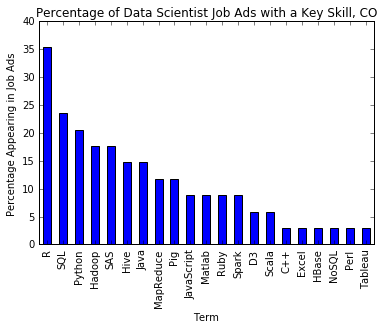

In [7]:
figure, frame = skills_info(state = 'CO')
frame.to_csv('COSkills.csv', index = False)

There were 30 jobs found, CT
Getting page 1
Getting page 2
Getting page 3
Done with collecting the job postings!
There were 13 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


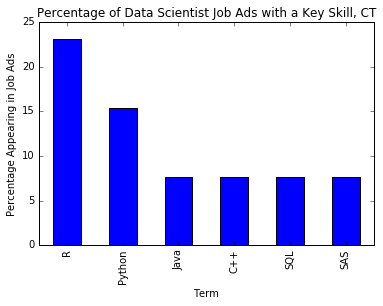

In [8]:
figure, frame = skills_info(state = 'CT')
frame.to_csv('CTSkills.csv', index = False)

In [11]:
#figure, frame = skills_info(state = 'DE')
#frame.to_csv('DESkills.csv', index = False)

There were 47 jobs found, FL
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Done with collecting the job postings!
There were 23 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


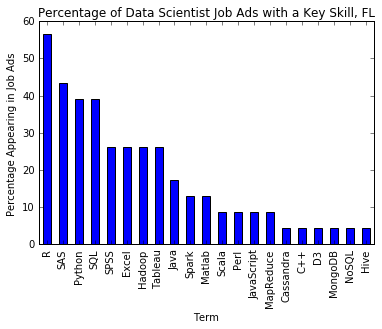

In [10]:
figure, frame = skills_info(state = 'FL')
frame.to_csv('FLSkills.csv', index = False)

There were 69 jobs found, GA
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Done with collecting the job postings!
There were 33 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


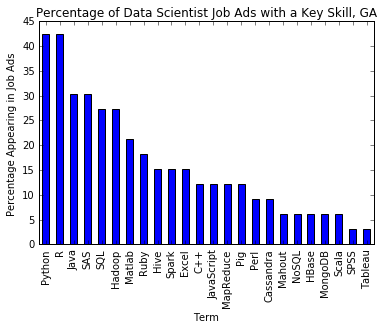

In [12]:
figure, frame = skills_info(state = 'GA')
frame.to_csv('GASkills.csv', index = False)

There were 139 jobs found, IL
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Done with collecting the job postings!
There were 92 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


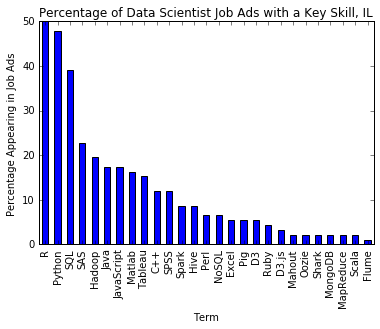

In [13]:
figure, frame = skills_info(state = 'IL')
frame.to_csv('ILSkills.csv', index = False)

There were 20 jobs found, IN
Getting page 1
Getting page 2
Done with collecting the job postings!
There were 10 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


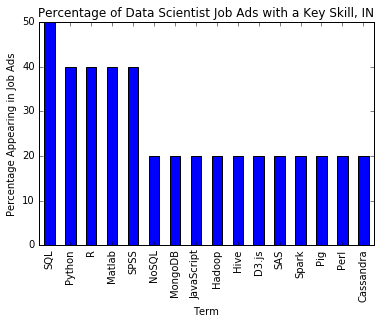

In [14]:
figure, frame = skills_info(state = 'IN')
frame.to_csv('INSkills.csv', index = False)

There were 74 jobs found, MD
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Done with collecting the job postings!
There were 57 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


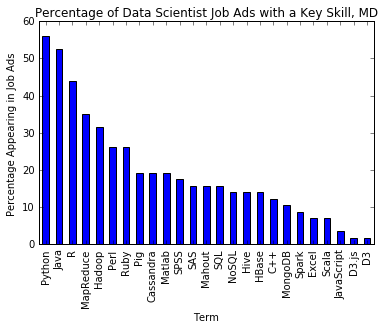

In [15]:
figure, frame = skills_info(state = 'MD')
frame.to_csv('MDSkills.csv', index = False)

There were 180 jobs found, MA
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Done with collecting the job postings!
There were 126 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


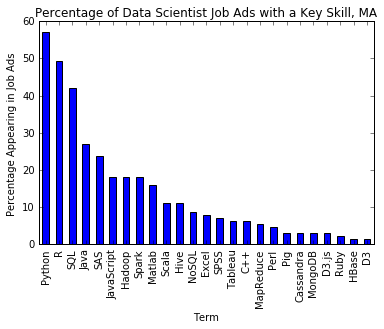

In [16]:
figure, frame = skills_info(state = 'MA')
frame.to_csv('MASkills.csv', index = False)

There were 54 jobs found, MI
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Done with collecting the job postings!
There were 17 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


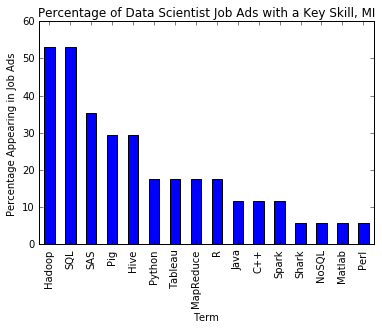

In [17]:
figure, frame = skills_info(state = 'MI')
frame.to_csv('MISkills.csv', index = False)

There were 21 jobs found, MN
Getting page 1
Getting page 2
Done with collecting the job postings!
There were 8 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


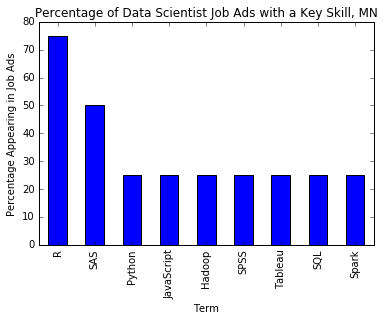

In [18]:
figure, frame = skills_info(state = 'MN')
frame.to_csv('MNSkills.csv', index = False)

There were 61 jobs found, MO
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Done with collecting the job postings!
There were 35 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


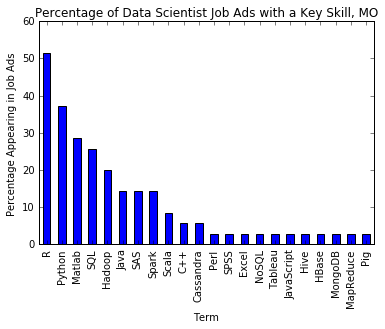

In [19]:
figure, frame = skills_info(state = 'MO')
frame.to_csv('MOSkills.csv', index = False)

There were 102 jobs found, NJ
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Done with collecting the job postings!
There were 48 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


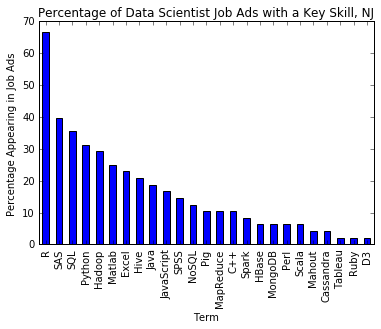

In [20]:
figure, frame = skills_info(state = 'NJ')
frame.to_csv('NJSkills.csv', index = False)

There were 330 jobs found, NY
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Done with collecting the job postings!
There were 219 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


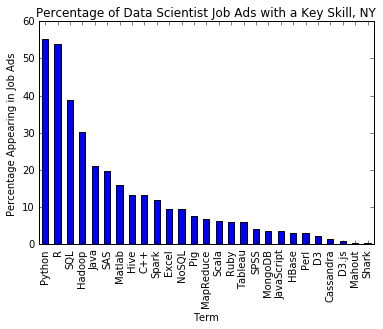

In [21]:
figure, frame = skills_info(state = 'NY')
frame.to_csv('NYSkills.csv', index = False)

There were 31 jobs found, NC
Getting page 1
Getting page 2
Getting page 3
Done with collecting the job postings!
There were 21 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


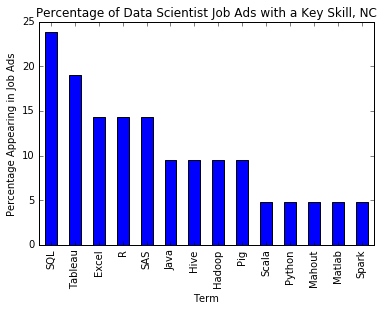

In [22]:
figure, frame = skills_info(state = 'NC')
frame.to_csv('NCSkills.csv', index = False)

There were 55 jobs found, OH
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Done with collecting the job postings!
There were 32 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


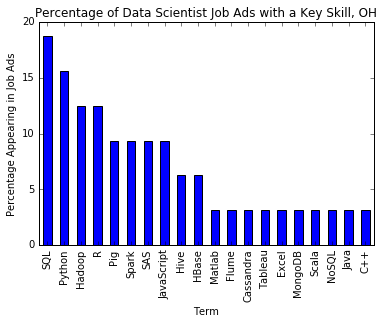

In [23]:
figure, frame = skills_info(state = 'OH')
frame.to_csv('OHSkills.csv', index = False)

There were 25 jobs found, OR
Getting page 1
Getting page 2
Done with collecting the job postings!
There were 6 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


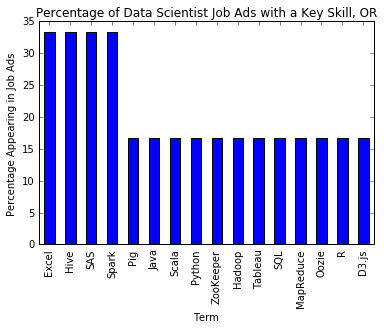

In [24]:
figure, frame = skills_info(state = 'OR')
frame.to_csv('ORSkills.csv', index = False)

There were 74 jobs found, PA
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Done with collecting the job postings!
There were 46 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


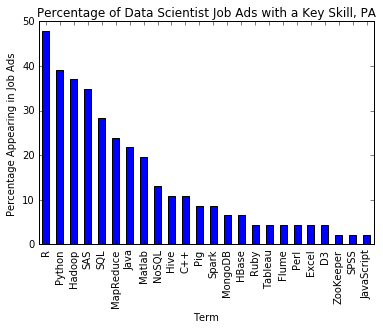

In [25]:
figure, frame = skills_info(state = 'PA')
frame.to_csv('PASkills.csv', index = False)

There were 19 jobs found, TN
Getting page 1
Done with collecting the job postings!
There were 5 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


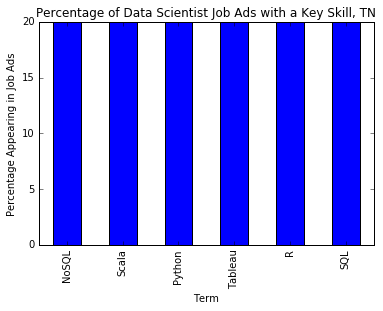

In [26]:
figure, frame = skills_info(state = 'TN')
frame.to_csv('TNSkills.csv', index = False)

There were 120 jobs found, TX
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Done with collecting the job postings!
There were 78 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


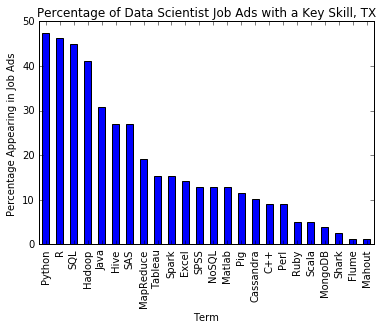

In [27]:
figure, frame = skills_info(state = 'TX')
frame.to_csv('TXSkills.csv', index = False)

There were 15 jobs found, UT
Getting page 1
Done with collecting the job postings!
There were 3 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


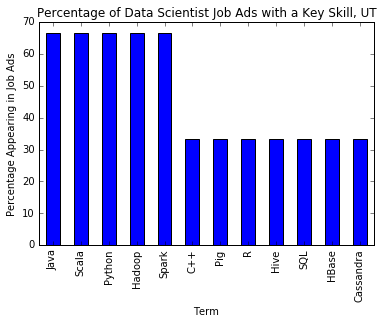

In [28]:
figure, frame = skills_info(state = 'UT')
frame.to_csv('UTSkills.csv', index = False)

There were 190 jobs found, VA
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Done with collecting the job postings!
There were 134 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


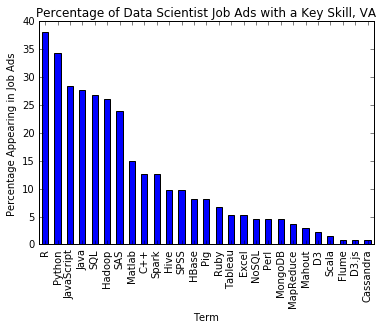

In [29]:
figure, frame = skills_info(state = 'VA')
frame.to_csv('VASkills.csv', index = False)

There were 227 jobs found, WA
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Done with collecting the job postings!
There were 184 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


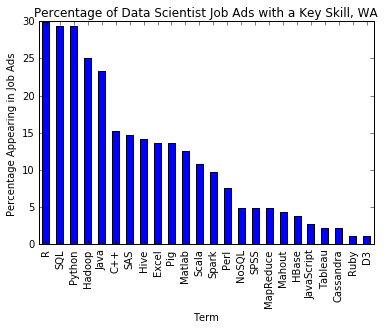

In [30]:
figure, frame = skills_info(state = 'WA')
frame.to_csv('WASkills.csv', index = False)

There were 25 jobs found, WI
Getting page 1
Getting page 2
Done with collecting the job postings!
There were 8 jobs successfully found.


/Users/Yathor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:130: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


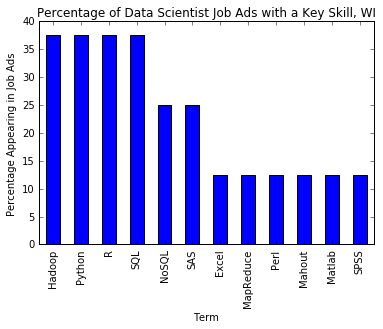

In [31]:
figure, frame = skills_info(state = 'WI')
frame.to_csv('WISkills.csv', index = False)